# A method to use the present_load to balance the leg of poppy

In [1]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep')

%pylab inline
#import time

la classe Poppy4dofArmMini est OK
Populating the interactive namespace from numpy and matplotlib


A trick to switch from real time to simulated time using time function (because my VREP is not in real time - about 3 times slower)

In [2]:
import time as real_time
class time:
    def __init__(self,robot):
        self.robot=robot
    def time(self):
        t_simu = self.robot.current_simulation_time
        return t_simu
    def sleep(self,t):
        t0 = self.robot.current_simulation_time
        while (self.robot.current_simulation_time - t0) < t-0.01:
            real_time.sleep(0.001)

time = time(poppy)
print time.time()
time.sleep(0.025) #0.025 is the minimum step according to the V-REP defined dt  
print time.time()

21.1748199463
21.1998195648


The present load of hip and ankle

In [3]:
print poppy.l_ankle_y.present_load
print poppy.r_ankle_y.present_load
print poppy.l_hip_y.present_load
print poppy.r_hip_y.present_load

1.74200996757
1.35683387518
-0.336985755712
0.318800968428


The present load function of time

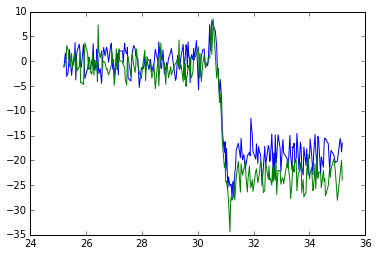

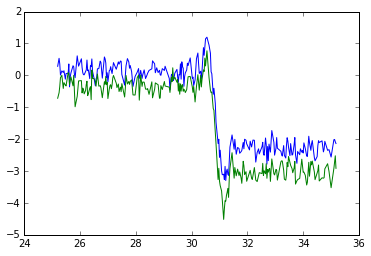

In [5]:
load_r = []
load_l = []
load1_r = []
load1_l = []
t = []
t0 = time.time()
while time.time()-t0 <5:
    t_simu = poppy.current_simulation_time
    time.sleep(0.01)
    if poppy.current_simulation_time != t_simu:
        
        load_r.append(poppy.r_ankle_y.present_load)
        load_l.append(poppy.l_ankle_y.present_load)
        load1_r.append(poppy.r_hip_y.present_load)
        load1_l.append(poppy.l_hip_y.present_load)
        t.append(poppy.current_simulation_time)
poppy.l_ankle_y.goto_position(-5, 1, wait=False)
poppy.r_ankle_y.goto_position(-5, 1, wait=False)
t0 = time.time()
while time.time()-t0 <5:
    t_simu = poppy.current_simulation_time
    time.sleep(0.01)
    if poppy.current_simulation_time != t_simu:
        
        load_r.append(poppy.r_ankle_y.present_load)
        load_l.append(poppy.l_ankle_y.present_load)
        load1_r.append(poppy.r_hip_y.present_load)
        load1_l.append(poppy.l_hip_y.present_load)
        t.append(poppy.current_simulation_time)
poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=True)   
        
        
figure(1)            
plot(t,load_r)
plot(t,load_l)
figure(2)
plot(t,load1_r)
plot(t,load1_l)


Integration of different present_load to have a more stable value.

In [3]:
class load:
    def __init__(self,nb_record=10,goal=0):
        self.nb_record = nb_record
        self.goal = goal
        self.record_pos=[0 for i in range(nb_record)]
        self.filter_load=[[0,0] for i in range(nb_record*10)]
        
    def add(self,l):
        self.record_pos.append(l-self.goal)
        del self.record_pos[0]
        self.filter_load.append([time.time(),sum(self.record_pos)/len(self.record_pos)])
        del self.filter_load[0]
    
    def integrate(self,nb_values=10):
        x=[i[0] for i in self.filter_load]
        y=[i[1] for i in self.filter_load]
        return np.trapz(y[-nb_values-1:-1],x[-nb_values-1:-1])
    
    def derivative(self):
        return (self.filter_load[-1][1]-self.filter_load[-3][1])/(self.filter_load[-1][0]-self.filter_load[-3][0])
    
    def last(self):
        return self.filter_load[-1][1]

We need a primitive to record the load :

In [4]:
from pypot.primitive import Primitive

class graph_primitive(Primitive):
    def setup(self):
        self.load_ankle = []
        self.load_hip = []
        self.t=[]
        self.correction = []
        self.position_ankle = []
    
    def run(self):
        while not self.should_stop():
            self.load_ankle.append(load_ankle.last())
            self.load_hip.append(load_hip.last())
            self.t.append(time.time())
            self.correction.append(correction_value)
            self.position_ankle.append(poppy.r_ankle_y.present_position)
            time.sleep(0.02)

Load of ankle and hip after an ankle movement.

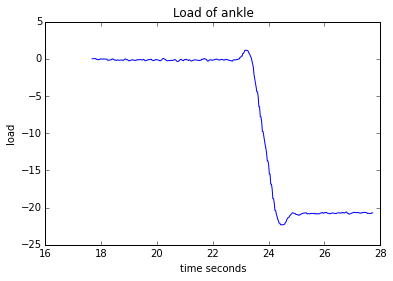

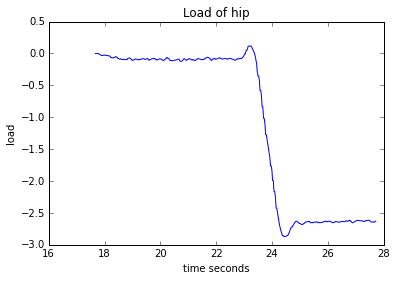

In [5]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0

graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    time.sleep(0.025)

poppy.l_ankle_y.goto_position(-5, 1, wait=False)
poppy.r_ankle_y.goto_position(-5, 1, wait=False)

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    time.sleep(0.025)

graph.stop()

poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')

Load of ankle and hip during a knee movement

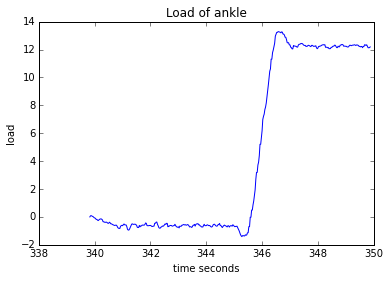

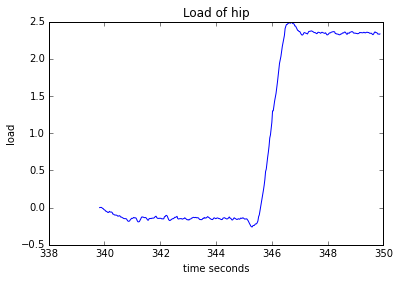

In [18]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0

graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

poppy.l_knee_y.goto_position(5, 1, wait=False)
poppy.r_knee_y.goto_position(5, 1, wait=False)

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

graph.stop()
    
poppy.l_knee_y.goto_position(0, 1, wait=False)
poppy.r_knee_y.goto_position(0, 1, wait=False) 
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')

On the previous graph, you can see the two forces in action during a movement. First, an inertia force due to the acceleration of the body. This force decrease the load of the motor for a short time and this force is in the opposite direction of the move. After, the load increase because the gravity center of poppy is moved behind poppy (in direction of the back of poppy). So, when poppy is balanced with his gravity center just above his feet, the load of the hip and ankle motors should be closed to zero.

Now, we are going to apply a very simple correction to maintien the load of ankle closed to zero.

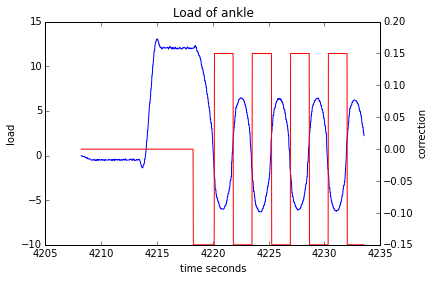

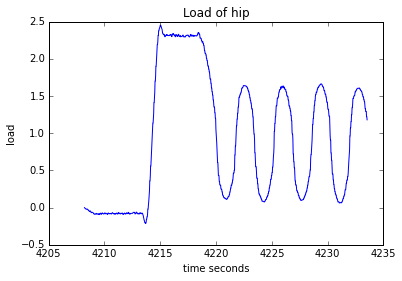

In [57]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0

graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

poppy.l_knee_y.goto_position(5, 1, wait=False)
poppy.r_knee_y.goto_position(5, 1, wait=False)


t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)
  
        
t0 = time.time()
while time.time()-t0 <15:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
        
    r_ankle_y_pos = poppy.r_ankle_y.present_position
    l_ankle_y_pos = poppy.l_ankle_y.present_position    
    
    if load_ankle.last() > 2:
        while load_ankle.last() > 2:
            correction_value = -0.15
            r_ankle_y_pos += correction_value
            l_ankle_y_pos += correction_value
            #print "load :",load_ankle.sum_load()
            #print "correction négative :",r_ankle_y_pos, l_ankle_y_pos
            poppy.r_ankle_y.goal_position = r_ankle_y_pos
            poppy.l_ankle_y.goal_position = l_ankle_y_pos
            time.sleep(0.05) # waiting for the movement to finish - according to the dt minimum define in VREP
            load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
            load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    elif load_ankle.last() < -2: 
        while load_ankle.last() < -2:
            correction_value = 0.15
            r_ankle_y_pos += correction_value
            l_ankle_y_pos += correction_value
            #print "load :",load_ankle.sum_load()
            #print "correction positive :",r_ankle_y_pos, l_ankle_y_pos
            poppy.r_ankle_y.goal_position = r_ankle_y_pos
            poppy.l_ankle_y.goal_position = r_ankle_y_pos
            time.sleep(0.05) # waiting for the movement to finish - according to the dt minimum define in VREP
            load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
            load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    else :
        #print "poppy is balanced"
        time.sleep(0.025)

graph.stop()
        
poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=False)

poppy.l_knee_y.goto_position(0, 1, wait=False)
poppy.r_knee_y.goto_position(0, 1, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle,"b-")
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')

The system is oscilating for two reasons :
* The correction have an action on the sensor. That means the correction movement create an inertia force which stop when the movement stop so the correction is two big when the movement stop and the movement restart on the other sens.
* There is a delay between the action of the correction and the action on the sensor.

What is possible to do to avoid the oscilation ? To **introduce a proportional correction** is better because the more close to the goal you are, the less correction you need.

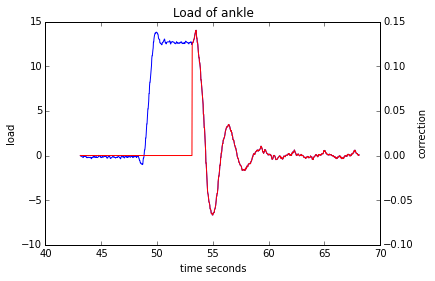

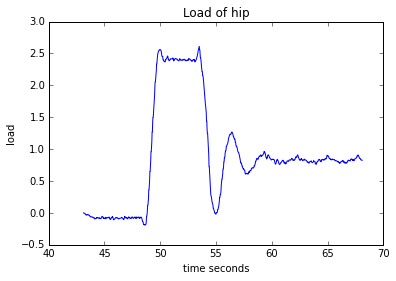

In [5]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0

graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
   
    time.sleep(0.025)

poppy.l_knee_y.goto_position(5, 1, wait=False)
poppy.r_knee_y.goto_position(5, 1, wait=False)


t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

    
r_ankle_y_pos = poppy.r_ankle_y.present_position
l_ankle_y_pos = poppy.l_ankle_y.present_position   

t0 = time.time()
while time.time()-t0 <15:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
           
    correction_value = 0.01*load_ankle.last()
    r_ankle_y_pos -= correction_value
    l_ankle_y_pos -= correction_value
    
    poppy.r_ankle_y.goal_position = r_ankle_y_pos
    poppy.l_ankle_y.goal_position = l_ankle_y_pos
    time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP
    
graph.stop()    
        
poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=False)

poppy.l_knee_y.goto_position(0, 1, wait=False)
poppy.r_knee_y.goto_position(0, 1, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')

The system stabilises after few oscillations. What is possible now is to introduce a derivated parameter.

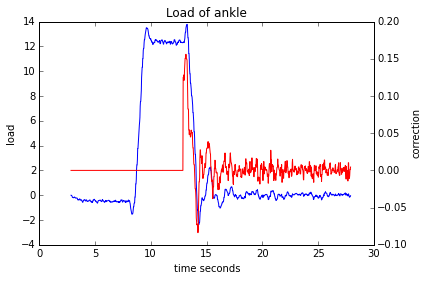

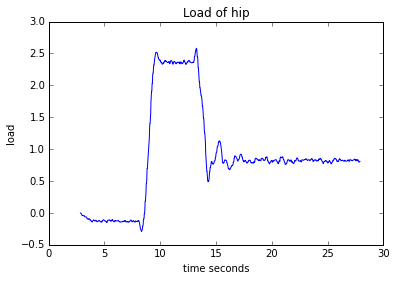

In [10]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0


graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
   
    time.sleep(0.025)

poppy.l_knee_y.goto_position(5, 1, wait=False)
poppy.r_knee_y.goto_position(5, 1, wait=False)


t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

    
r_ankle_y_pos = poppy.r_ankle_y.present_position
l_ankle_y_pos = poppy.l_ankle_y.present_position   

t0 = time.time()
while time.time()-t0 <15:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
           
    correction_value = 0.01*load_ankle.last()+0.003*load_ankle.derivative()
    r_ankle_y_pos -= correction_value
    l_ankle_y_pos -= correction_value
    
    
    poppy.r_ankle_y.goal_position = r_ankle_y_pos
    poppy.l_ankle_y.goal_position = l_ankle_y_pos
    time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP
    
graph.stop()    
        
poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=False)

poppy.l_knee_y.goto_position(0, 1, wait=False)
poppy.r_knee_y.goto_position(0, 1, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')

It is possible to add one more correction, in function of the integration of the difference between real load and goal load.

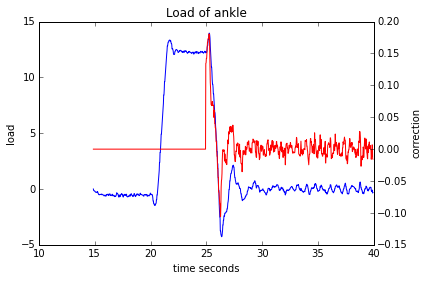

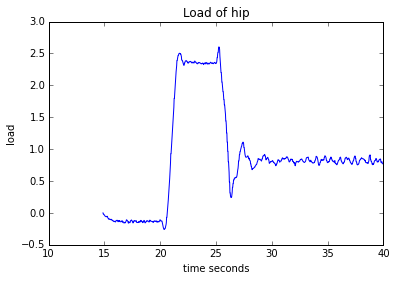

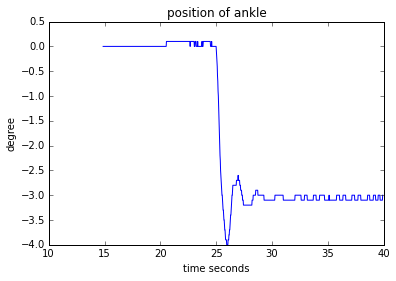

In [13]:
graph = graph_primitive(poppy)

load_ankle = load(40)
load_hip = load(40)
correction_value = 0


graph.start()

t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
   
    time.sleep(0.025)

poppy.l_knee_y.goto_position(5, 1, wait=False)
poppy.r_knee_y.goto_position(5, 1, wait=False)


t0 = time.time()
while time.time()-t0 <5:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
    
    time.sleep(0.025)

    
r_ankle_y_pos = poppy.r_ankle_y.present_position
l_ankle_y_pos = poppy.l_ankle_y.present_position   

t0 = time.time()
while time.time()-t0 <15:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
           
    
    correction_value = 0.01*load_ankle.last()+0.003*load_ankle.derivative()+0.002*load_ankle.integrate(30)
    r_ankle_y_pos -= correction_value
    l_ankle_y_pos -= correction_value
    
    
    poppy.r_ankle_y.goal_position = r_ankle_y_pos
    poppy.l_ankle_y.goal_position = l_ankle_y_pos
    time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP
    
graph.stop()    
        
poppy.l_ankle_y.goto_position(0, 1, wait=False)
poppy.r_ankle_y.goto_position(0, 1, wait=False)

poppy.l_knee_y.goto_position(0, 1, wait=False)
poppy.r_knee_y.goto_position(0, 1, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')
figure(3)
plot(graph.t,graph.position_ankle)
xlabel('time seconds')
ylabel('degree')
title ('position of ankle')

The correction is now more efficient. The correction is a kind of PID controller, if you like the theory and mathematics, more explanations [here](http://en.wikipedia.org/wiki/PID_controller).

Now, we want to correct the balance when the knee are moving (and not after, like in the previous examples).

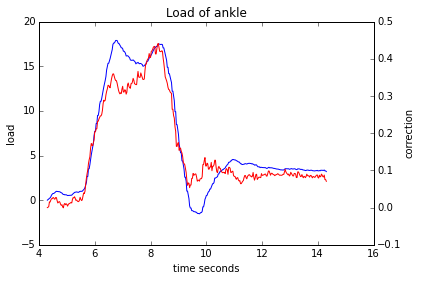

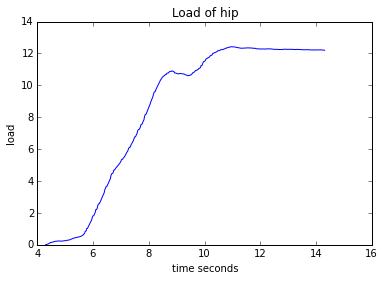

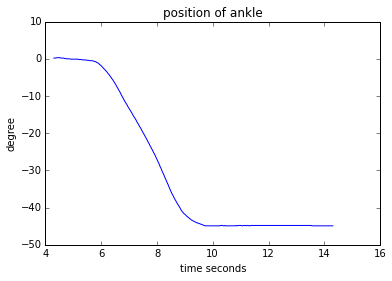

In [84]:
time.sleep(1)

graph = graph_primitive(poppy)

load_ankle = load(nb_record=40,goal=0)
load_hip = load(40)
correction_value = 0

poppy.l_knee_y.goto_position(70, 6, wait=False)
poppy.r_knee_y.goto_position(70, 6, wait=False)

graph.start()

r_ankle_y_pos = poppy.r_ankle_y.present_position
l_ankle_y_pos = poppy.l_ankle_y.present_position   

t0 = time.time()
while time.time()-t0 <10:
    load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
    load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)
     
    correction_value = 0.015*load_ankle.last()+0.004*load_ankle.derivative()+0.005*load_ankle.integrate(80)
    r_ankle_y_pos -= correction_value
    l_ankle_y_pos -= correction_value
   
    poppy.r_ankle_y.goal_position = r_ankle_y_pos
    poppy.l_ankle_y.goal_position = l_ankle_y_pos
    time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP
    
graph.stop()    
        
poppy.l_ankle_y.goto_position(0, 1.5, wait=False)
poppy.r_ankle_y.goto_position(0, 1.5, wait=False)

poppy.l_knee_y.goto_position(0, 1.5, wait=False)
poppy.r_knee_y.goto_position(0, 1.5, wait=True)   
        
figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')
figure(3)
plot(graph.t,graph.position_ankle)
xlabel('time seconds')
ylabel('degree')
title ('position of ankle')

We can control several motor with the same method, for example we can add the hip.

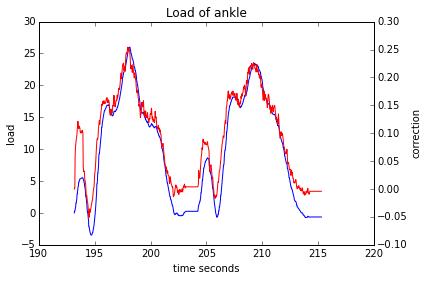

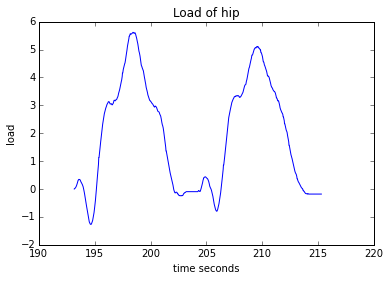

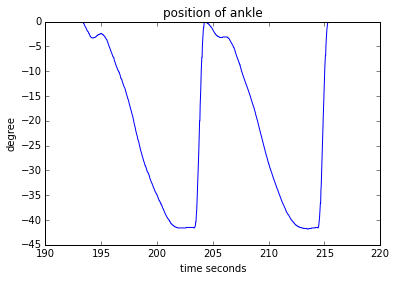

In [107]:
time.sleep(1)

graph = graph_primitive(poppy)

load_ankle = load(nb_record=40,goal=-8)
load_hip = load(40)
correction_value = 0
correction_value_hip = 0

graph.start()
i=0
while i<2 :
    poppy.l_knee_y.goto_position(80, 9, wait=False)
    poppy.r_knee_y.goto_position(80, 9, wait=False)

    r_ankle_y_pos = poppy.r_ankle_y.present_position
    l_ankle_y_pos = poppy.l_ankle_y.present_position   

    r_hip_y_pos = poppy.r_hip_y.present_position
    l_hip_y_pos = poppy.l_hip_y.present_position   

    t0 = time.time()
    while time.time()-t0 <10:
        load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
        load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)


        correction_value = 0.008*load_ankle.last()+0.002*load_ankle.derivative()+0.002*load_ankle.integrate(30)
        r_ankle_y_pos -= correction_value
        l_ankle_y_pos -= correction_value
        poppy.r_ankle_y.goal_position = r_ankle_y_pos
        poppy.l_ankle_y.goal_position = l_ankle_y_pos

        correction_value_hip = 0.04*load_hip.last()+0.006*load_hip.derivative()+0.008*load_hip.integrate(30)
        r_hip_y_pos -= correction_value_hip
        l_hip_y_pos -= correction_value_hip
        poppy.r_hip_y.goal_position = r_hip_y_pos
        poppy.l_hip_y.goal_position = l_hip_y_pos


        time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP

    poppy.l_ankle_y.goto_position(0, 1, wait=False)
    poppy.r_ankle_y.goto_position(0, 1, wait=False)

    poppy.l_hip_y.goto_position(0, 1, wait=False)
    poppy.r_hip_y.goto_position(0, 1, wait=False)   

    poppy.l_knee_y.goto_position(0, 1, wait=False)
    poppy.r_knee_y.goto_position(0, 1, wait=True)   
    i+=1

graph.stop()  

figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')
figure(3)
plot(graph.t,graph.position_ankle)
xlabel('time seconds')
ylabel('degree')
title ('position of ankle')

Another try with a control during the descent and the rise. And also other PID parameters.

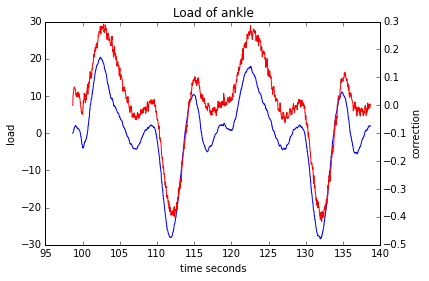

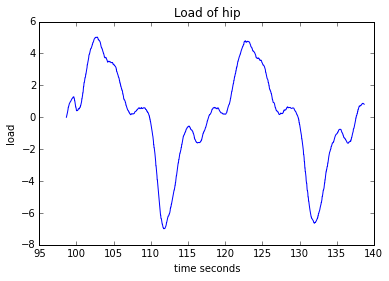

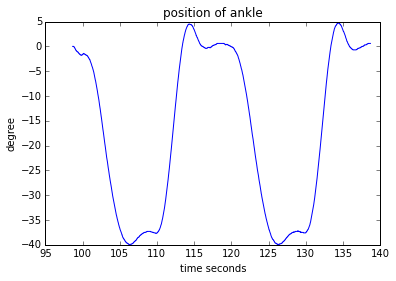

In [6]:
time.sleep(1)

graph = graph_primitive(poppy)

load_ankle = load(nb_record=40,goal=-4)
load_hip = load(40,goal=-2)
correction_value = 0
correction_value_hip = 0

graph.start()
i=0
while i<2 :
    poppy.l_knee_y.goto_position(80, 8, wait=False)
    poppy.r_knee_y.goto_position(80, 8, wait=False)

    r_ankle_y_pos = poppy.r_ankle_y.present_position
    l_ankle_y_pos = poppy.l_ankle_y.present_position   

    r_hip_y_pos = poppy.r_hip_y.present_position
    l_hip_y_pos = poppy.l_hip_y.present_position   

    t0 = time.time()
    while time.time()-t0 <10:
        load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
        load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)


        correction_value = 0.008*load_ankle.last()+0.003*load_ankle.derivative()+0.005*load_ankle.integrate(80)
        r_ankle_y_pos -= correction_value
        l_ankle_y_pos -= correction_value
        poppy.r_ankle_y.goal_position = r_ankle_y_pos
        poppy.l_ankle_y.goal_position = l_ankle_y_pos

        correction_value_hip = 0.04*load_hip.last()+0.006*load_hip.derivative()+0.008*load_hip.integrate(50)
        r_hip_y_pos -= correction_value_hip
        l_hip_y_pos -= correction_value_hip
        poppy.r_hip_y.goal_position = r_hip_y_pos
        poppy.l_hip_y.goal_position = l_hip_y_pos


        time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP

    
    poppy.l_knee_y.goto_position(0, 6, wait=False)
    poppy.r_knee_y.goto_position(0, 6, wait=False)
    t0 = time.time()
    while time.time()-t0 <10:
        load_ankle.add((poppy.r_ankle_y.present_load+poppy.l_ankle_y.present_load)/2)
        load_hip.add((poppy.r_hip_y.present_load+poppy.l_hip_y.present_load)/2)


        correction_value = 0.008*load_ankle.last()+0.003*load_ankle.derivative()+0.005*load_ankle.integrate(80)
        r_ankle_y_pos -= correction_value
        l_ankle_y_pos -= correction_value
        poppy.r_ankle_y.goal_position = r_ankle_y_pos
        poppy.l_ankle_y.goal_position = l_ankle_y_pos

        correction_value_hip = 0.04*load_hip.last()+0.006*load_hip.derivative()+0.008*load_hip.integrate(50)
        r_hip_y_pos -= correction_value_hip
        l_hip_y_pos -= correction_value_hip
        poppy.r_hip_y.goal_position = r_hip_y_pos
        poppy.l_hip_y.goal_position = l_hip_y_pos


        time.sleep(0.025) # waiting for the movement to finish - according to the dt minimum define in VREP

    
    i+=1


    
graph.stop()  

poppy.l_ankle_y.goto_position(0, 2, wait=False)
poppy.r_ankle_y.goto_position(0, 2, wait=False)

poppy.l_hip_y.goto_position(0, 2, wait=False)
poppy.r_hip_y.goto_position(0, 2, wait=False)   

poppy.l_knee_y.goto_position(0, 2, wait=False)
poppy.r_knee_y.goto_position(0, 2, wait=False)   

figure(1)            
plot(graph.t,graph.load_ankle)
xlabel('time seconds')
ylabel('load')
twinx()
plot(graph.t,graph.correction,"r-")
ylabel('correction')
title ('Load of ankle')
figure(2)
plot(graph.t,graph.load_hip)
xlabel('time seconds')
ylabel('load')
title ('Load of hip')
figure(3)
plot(graph.t,graph.position_ankle)
xlabel('time seconds')
ylabel('degree')
title ('position of ankle')

In [ ]:
from pypot.primitive import Primitive

class load_primitive(Primitive):
    def __init__(self,robot,motors_name,nb_records,goal):
        # if you give more than one motor, the load for the motors will be combined, if you want independant 
        # load you have to instantiate several primitives
        self.robot = robot
        self.motors = [getattr(self.robot, name) for name in motors_name]
        self.nb_records = nb_records
        self.goal = goal
        correction_value = 0
        Primitive.__init__(self, robot)
        
    def run(self):    
        
        load = load(nb_record=40,goal=-4)
        
        correction_value = 0
        correction_value_hip = 0
    
    